### Importing Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf

### Data Collection

In [ ]:
path = r"/kaggle/input/burdur/ Burdur_lake"

data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (256, 256), batch_size = 6000, shuffle = False)

Found 760 files belonging to 2 classes.


In [ ]:
for images, masks in data:
    X = images.numpy().astype("uint8")
    y = masks.numpy().astype("uint8")

print(X.shape, y.shape)

(760, 256, 256, 3) (760,)


In [ ]:
images = X[y == 0]
masks = X[y == 1]

print(images.shape, masks.shape)

(380, 256, 256, 3) (380, 256, 256, 3)


### Data Visualization

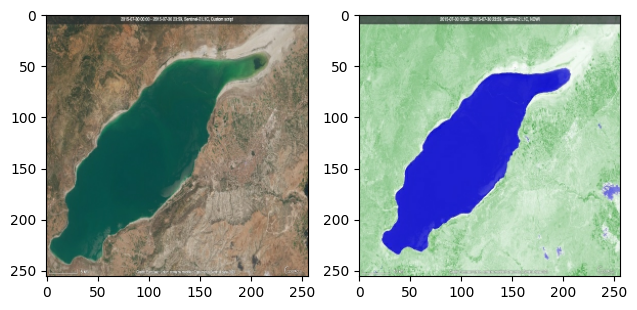

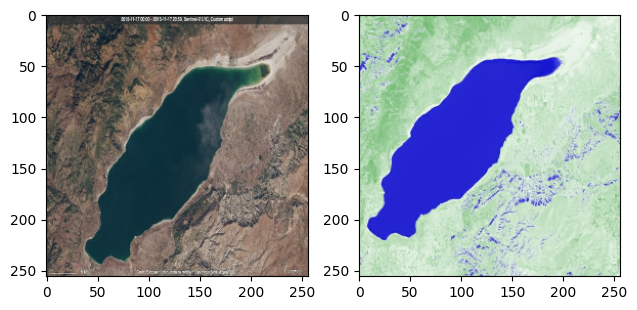

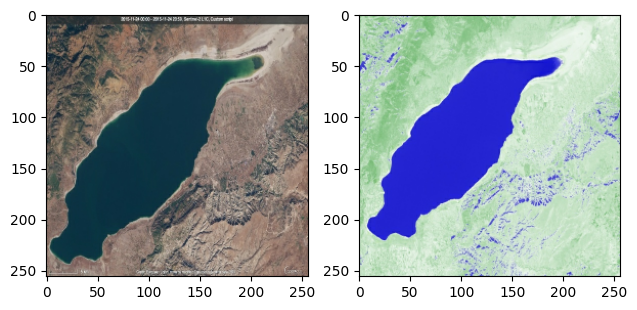

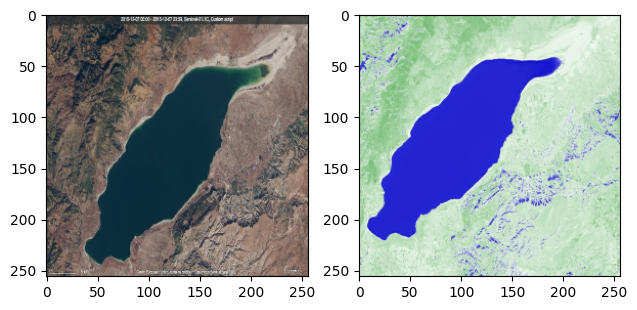

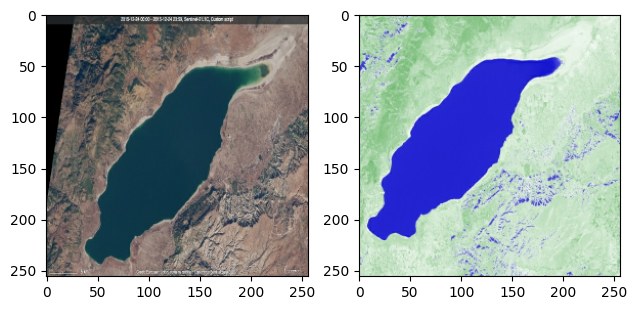

In [ ]:
for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(images[i])

    plt.subplot(1, 2, 2)
    plt.imshow(masks[i])

    plt.tight_layout()
    plt.show()

### Data Preprocessing and Preparation

In [ ]:
X = np.zeros(shape = images.shape[:-1] + (1, ))
y = np.zeros(shape = masks.shape[:-1] + (1, ))

for i in range(X.shape[0]):
    X[i] = tf.image.rgb_to_grayscale(images[i])
    y[i] = tf.image.rgb_to_grayscale(masks[i])

print(X.shape, y.shape)

(380, 256, 256, 1) (380, 256, 256, 1)


In [ ]:
X = X / 255.0
y = y / 255.0

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 3)

print(X_train.shape, X_test.shape)

(304, 256, 256, 1) (76, 256, 256, 1)


### Model Building and Training

In [ ]:
def encoder_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(inputs)
    x = tf.keras.layers.Activation('elu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.Activation('elu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2)(x)
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(inputs)
    skip_features = tf.image.resize(skip_features, size = (x.shape[1], x.shape[2]))
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.Activation('elu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.Activation('elu')(x)
    return x

In [ ]:
def unet_model(input_shape = (128, 128, 1), num_classes = 1):
    inputs = tf.keras.layers.Input(shape = input_shape)

    s1 = encoder_block(inputs, 50)
    s2 = encoder_block(s1, 100)
    s3 = encoder_block(s2, 150)
    s4 = encoder_block(s3, 200)

    b1 = tf.keras.layers.Conv2D(filters = 100, kernel_size = (3, 3), padding = "same", kernel_initializer = "he_uniform")(s4)
    b1 = tf.keras.layers.Activation('elu')(b1)
    b1 = tf.keras.layers.Conv2D(filters = 100, kernel_size = (3, 3), padding = "same", kernel_initializer = "he_uniform")(b1)
    b1 = tf.keras.layers.Activation('elu')(b1)

    s5 = decoder_block(b1, s4, 200)
    s6 = decoder_block(s5, s3, 150)
    s7 = decoder_block(s6, s2, 100)
    s8 = decoder_block(s7, s1, 50)

    outputs = tf.keras.layers.Conv2D(filters = num_classes, kernel_size = (1, 1), padding = "same", activation = "sigmoid")(s8)

    model = tf.keras.models.Model(inputs = [inputs], outputs = [outputs], name = 'U-Net')
    return model

In [ ]:
model = unet_model(input_shape = (256, 256, 1), num_classes = 1)

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 50)         500       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 50)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 50)         22550     ['activation[0][0]']          
                                                                                              

In [ ]:
model.compile(optimizer = "adam", loss = "BinaryCrossentropy", metrics = "accuracy")

c1 = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs = 50, validation_split = 0.2, callbacks = [c1])

Epoch 1/50
8/8 [==============================] - 265s 33s/step - loss: 0.9490 - accuracy: 3.5365e-04 - val_loss: 0.6333 - val_accuracy: 4.5276e-04
Epoch 2/50
8/8 [==============================] - 259s 32s/step - loss: 0.5783 - accuracy: 3.0059e-04 - val_loss: 0.5577 - val_accuracy: 4.4426e-04
Epoch 3/50
8/8 [==============================] - 257s 32s/step - loss: 0.5545 - accuracy: 3.0756e-04 - val_loss: 0.5550 - val_accuracy: 3.1743e-04
Epoch 4/50
8/8 [==============================] - 260s 33s/step - loss: 0.5524 - accuracy: 3.7337e-04 - val_loss: 0.5549 - val_accuracy: 7.1566e-04
Epoch 5/50
8/8 [==============================] - 263s 33s/step - loss: 0.5475 - accuracy: 4.0922e-04 - val_loss: 0.5468 - val_accuracy: 8.9176e-04
Epoch 6/50
8/8 [==============================] - 260s 33s/step - loss: 0.5440 - accuracy: 4.3937e-04 - val_loss: 0.5483 - val_accuracy: 9.9032e-04
Epoch 7/50
8/8 [==============================] - 256s 32s/step - loss: 0.5429 - accuracy: 4.5601e-04 - val_loss

### Model Evaluation

In [ ]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 24s 7s/step - loss: 0.5150 - accuracy: 1.7748e-04


[0.515038788318634, 0.000177483816514723]

In [ ]:
y_test_pred = (model.predict(X_test) > 0.5).astype(int)

def compare(i):
    plt.subplot(1, 2, 1)
    plt.imshow(y_test[i])

    plt.subplot(1, 2, 2)
    plt.imshow(y_test_pred[i])

    plt.tight_layout()
    plt.show()

3/3 [==============================] - 24s 7s/step


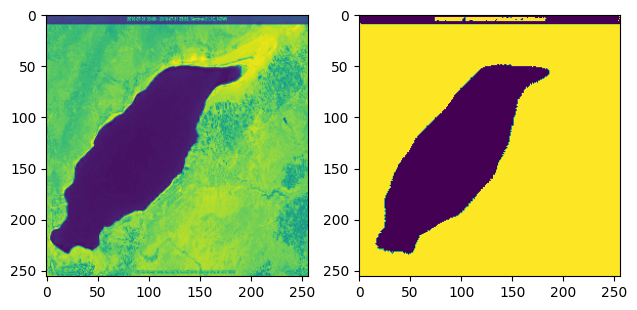

In [ ]:
compare(1)

In [ ]:
clf_report = metrics.classification_report((y_test > 0.5).astype(int).flatten(), y_test_pred.flatten())

print(clf_report)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94   1120946
           1       0.98      0.99      0.98   3859790

    accuracy                           0.97   4980736
   macro avg       0.97      0.96      0.96   4980736
weighted avg       0.97      0.97      0.97   4980736



In [ ]:
print("Jaccard Score", metrics.jaccard_score((y_test > 0.5).astype(int).flatten(), y_test_pred.flatten()))

Jaccard Score 0.9681732379485268


### Saving the Model

In [ ]:
model.save("model1.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


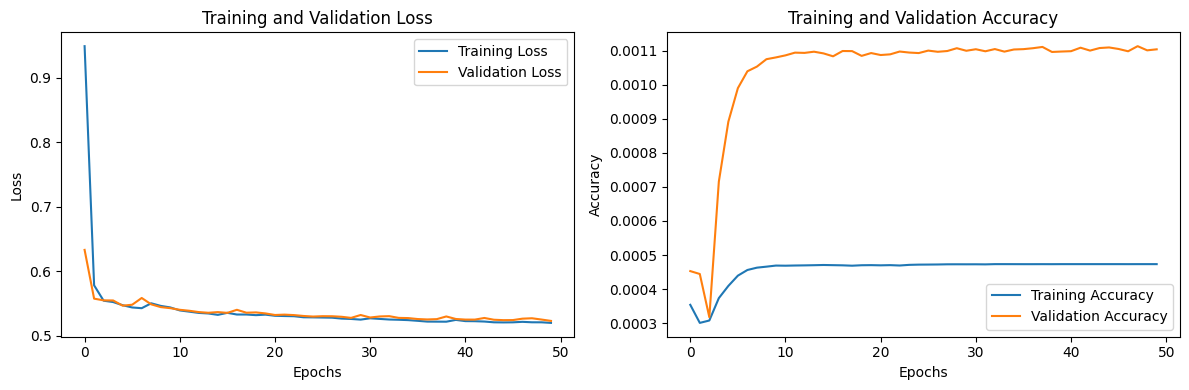

In [ ]:
import matplotlib.pyplot as plt


# Eğitim sırasında elde edilen metrik değerleri alın
loss_values = history.history['loss']
accuracy_values = history.history['accuracy']
val_loss_values = history.history['val_loss']
val_accuracy_values = history.history['val_accuracy']

# Loss grafiği
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(accuracy_values, label='Training Accuracy')
plt.plot(val_accuracy_values, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
